# Sub-genre Analysis: Analyze the subgenres of the *everynoise* network

In [2]:
# Imports
import numpy as np
import pandas as pd 
import networkx as nx
import community
import ast
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


## Load the Data

In [3]:
df_allG = pd.read_csv('all_genres.csv')
df_allG.head()

,Unnamed: 0,GENRE,SIM_GENRES,SIM_WEIGHTS,OPP_GENRES,OPP_WEIGHTS,REL_ARTISTS,ARTIST_WEIGHTS,SPOTIFY_URL
0,0,backgroundmusic,"['reiki', 'calminginstrumental', 'yoga', 'back...","['103', '120', '101', '240', '102', '125', '11...","['mahraganat', 'divahouse', 'oldschoolukhiphop...","['160', '100', '121', '110', '135', '136', '12...","['NoemiNucci', 'JuditheAbelsen', 'FabienneWill...","['113', '117', '106', '131', '109', '115', '11...",https://open.spotify.com/user/thesoundsofspoti...
1,1,classicmoroccanpop,"['bluesrock', 'andalusianclassical', 'chaabima...","['103', '107', '109', '100', '102', '103', '10...","['shiverpop', 'gravewave', 'tassieindie', 'est...","['112', '112', '105', '102', '124', '100', '16...","['HajHusseinToulali', 'AbdelhadiBelkheyat', 'H...","['102', '103', '103', '108', '108', '102', '10...",https://open.spotify.com/user/thesoundsofspoti...
2,2,orthodoxchant,"['universitychoir', 'polishchoir', 'ukrainianc...","['102', '105', '107', '104', '106', '240', '10...","['sambass', 'funkybreaks', 'hardbass', 'hardco...","['107', '110', '158', '100', '119', '111', '10...","['LegeArtis', 'PeterMichaelides', 'CapellaGreg...","['114', '100', '160', '127', '115', '115', '10...",https://open.spotify.com/user/thesoundsofspoti...
3,3,tar,"['oud', 'persiantraditional', 'bansuri', 'tar'...","['106', '120', '101', '240', '103', '113', '10...","['happyhardcore', 'aggrotech', 'nightcore', 'b...","['109', '107', '127', '114', '115', '120', '12...","['KiyarashSaket', 'YusefForutan', 'HamidMoteba...","['100', '100', '111', '100', '100', '100', '10...",https://open.spotify.com/user/thesoundsofspoti...
4,4,reggae,"['dancehall', 'brazilianreggae', 'skarevival',...","['109', '105', '114', '101', '100', '127', '11...","['brazilianlo-firock', 'martialindustrial', 'p...","['106', '107', '155', '121', '160', '108', '14...","['TheItals', 'MykalRose', 'JohnnieClark', 'Asw...","['101', '102', '100', '105', '101', '105', '10...",https://open.spotify.com/user/thesoundsofspoti...


## Construct the Weighted Graph based on Similar Genres where $\vert SIM\_GENRES \vert > n$
Where $n$ is the number of edges / connections for a genre.

### Functions

In [18]:
'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the set of genres

Useful for checking the genres that have over <support> connections.
'''
def set_genre(df, support: int = -1):
    set_genres = set()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        
         # Only add the (node,edges) into the set if the number of connections is greater than the support
        if len(connections) > support:
            set_genres.add(row['GENRE'])
            set_genres.update(connections)
    return (support, set_genres)

'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the graph
n: The number of rows to traverse on the Dataframe (only useful for testing)
'''
def generate_G(df, support: int = -1, n: int = 5000):
    G = nx.Graph()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        weights = ast.literal_eval(row['SIM_WEIGHTS'])
        
        # Only add the (node,edges) if the number of connections is greater than the support
        if len(connections) > support:
            G.add_node(row['GENRE'])
            edges = [(row['GENRE'], connections[i], int(weights[i])) for i in range(len(connections))]
            G.add_weighted_edges_from(edges)
            
        # Useful if you only need a small sample (for testing mainly)
        if idx == n:
            break
    return G

def plot_network(G, set_genres):
    plt.rcParams['figure.dpi'] = 300

    fig, ax = plt.subplots(1, figsize = (16,9))

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist = list(set_genres), node_size = 20, alpha = 1)
    nx.draw_networkx_edges(G, pos, width = 1.0, alpha = 1, connectionstyle = 'arc3, rad=1')
#     labels = nx.draw_networkx_labels(G, pos, font_size = 3)

    ax.axis('off')
    plt.show()
#     fig.savefig('./images/spring_layout_subgenres.pdf', bbox_inches='tight')

### What can various support sizes tell us about the *everynoise* network?

In [5]:
subgenre_sets = Parallel(n_jobs = -3, verbose = 2, batch_size = 'auto')(delayed(set_genre)(df_allG, i) for i in np.arange(76))


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-3)]: Done  76 out of  76 | elapsed:   12.1s finished


In [7]:
num_connections, sub_sets = zip(*sorted(subgenre_sets, key = lambda s: s[0]))
subgenre_lengths = np.array(list(map(len, sub_sets)))

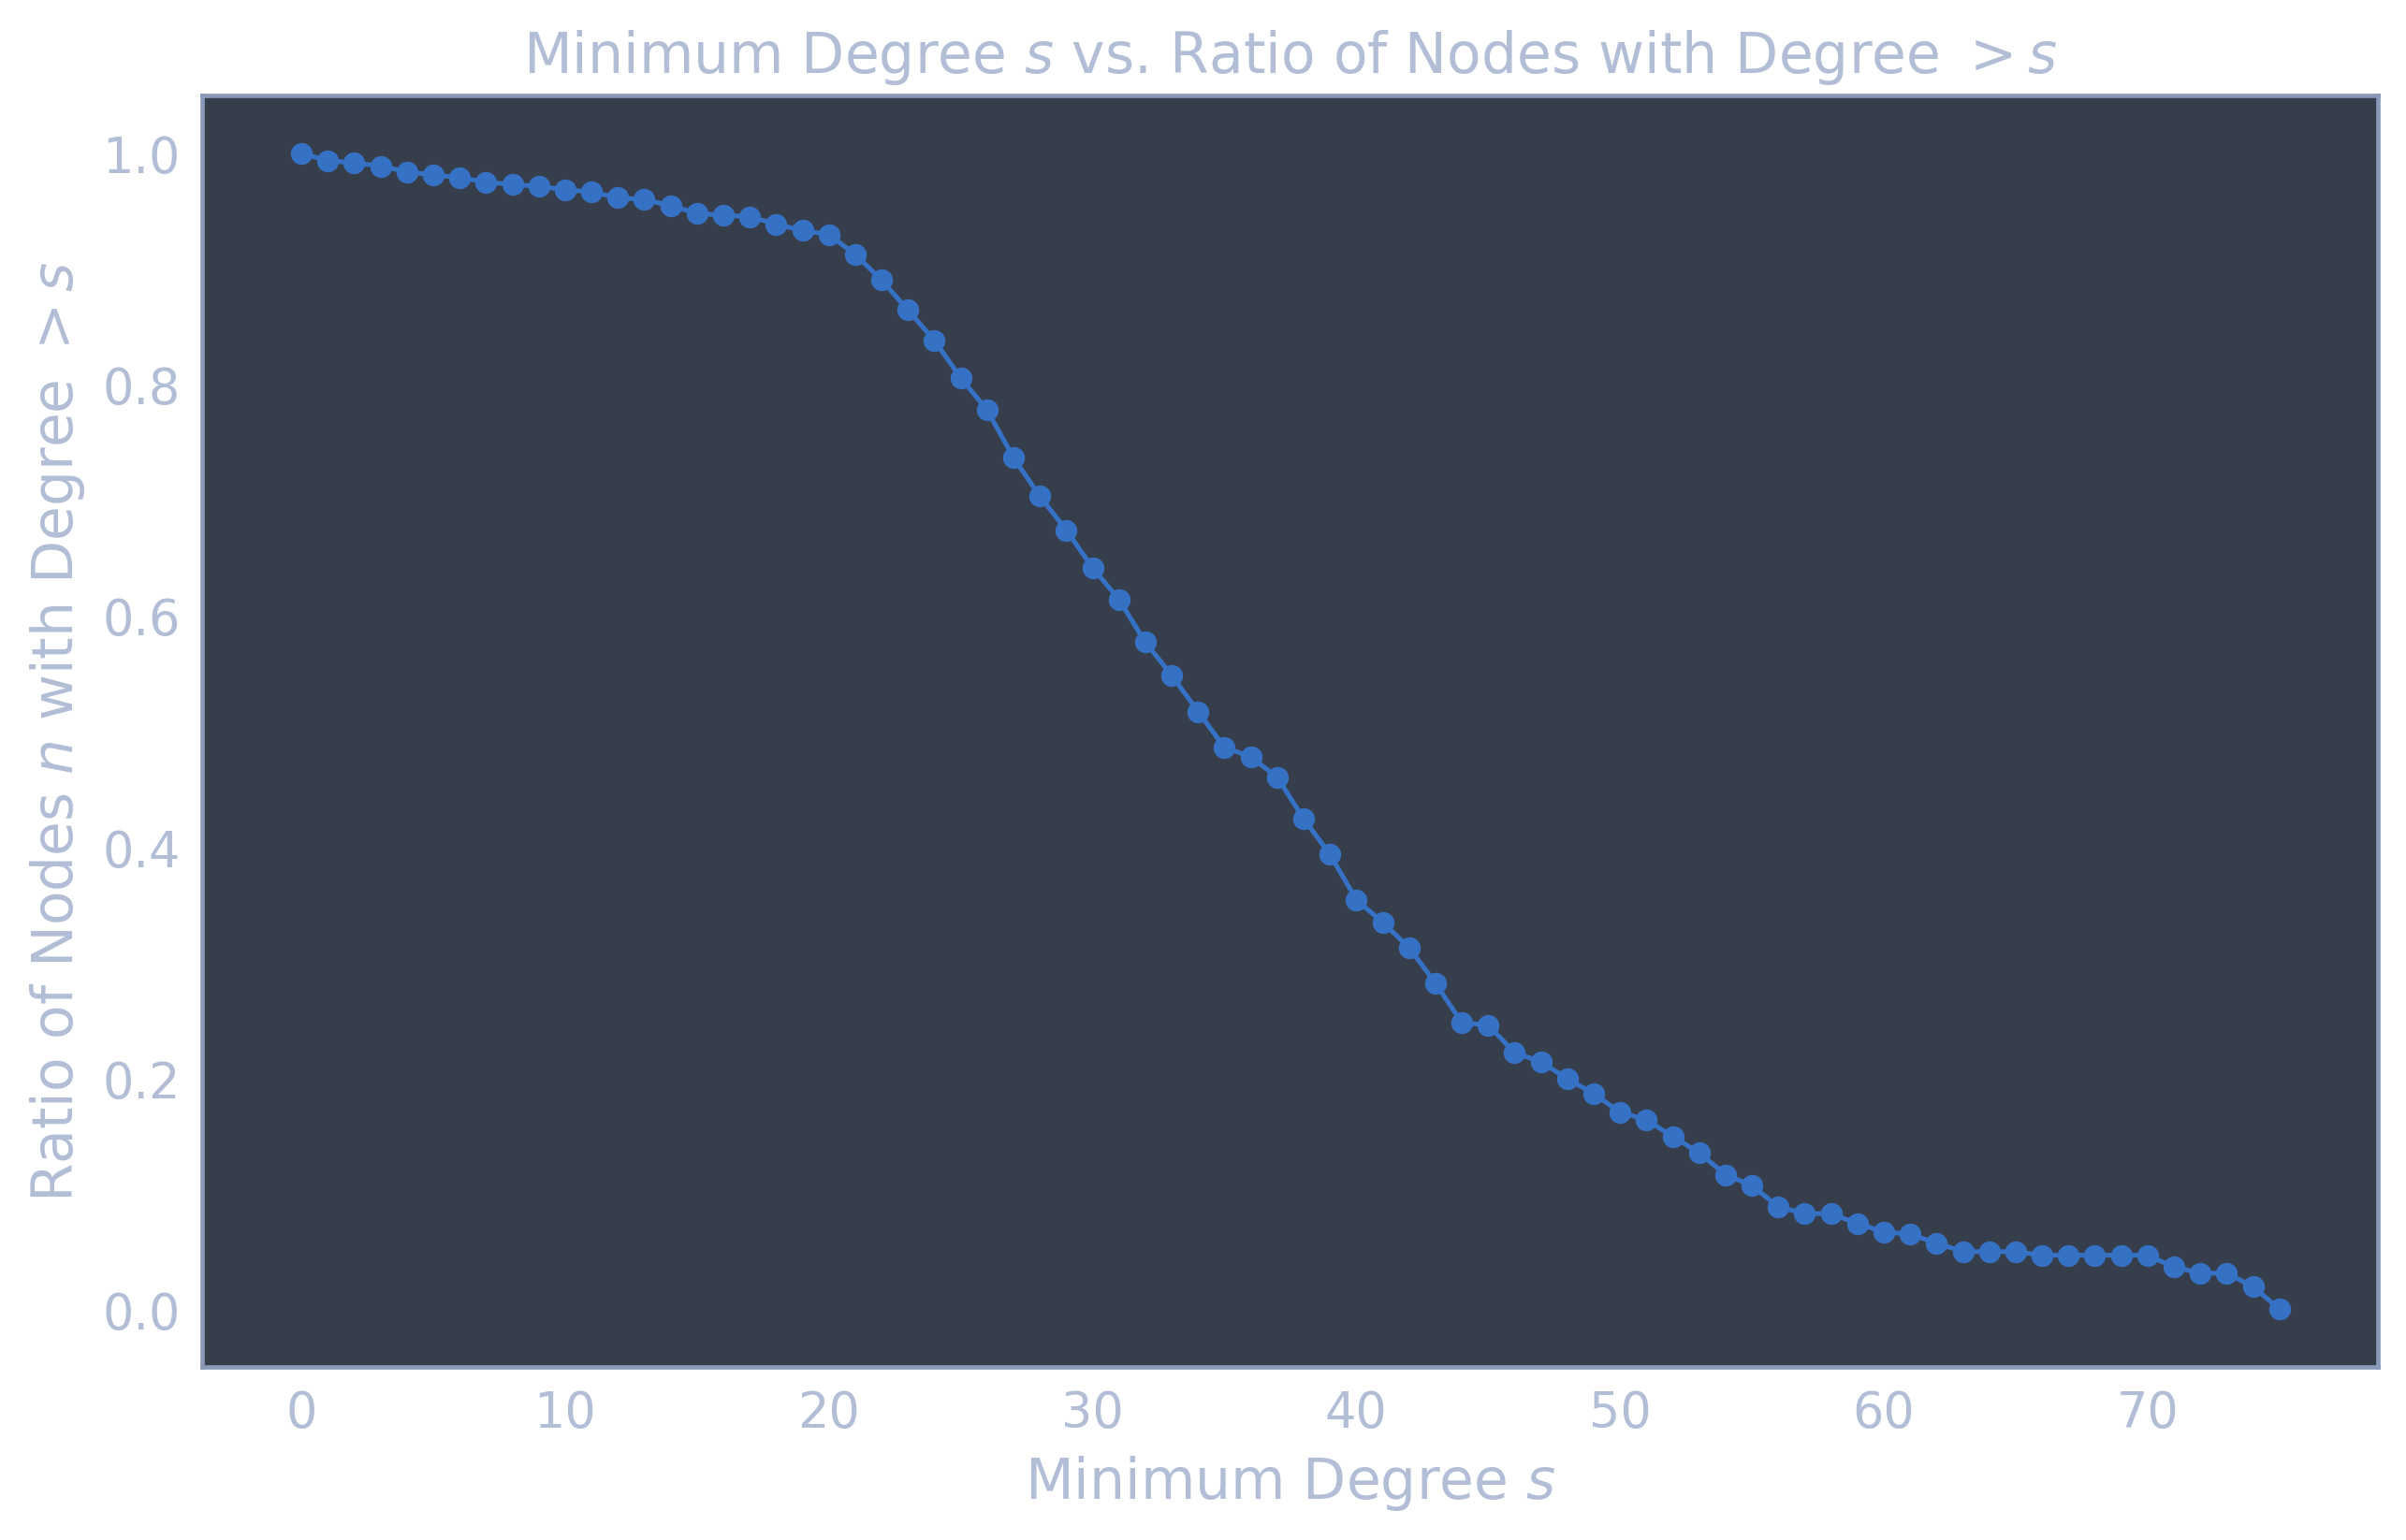

In [8]:
plt.rcParams['figure.dpi'] = 300
fig1, ax1 = plt.subplots(1, figsize = (10,6))
ax1.plot(num_connections, subgenre_lengths / subgenre_lengths[0], '-o')
ax1.set_xlabel(r'Minimum Degree $s$')
ax1.set_ylabel(r'Ratio of Nodes $n$ with Degree $>s$')
ax1.set_title(r'Minimum Degree $s$ vs. Ratio of Nodes with Degree $>s$')
ax1.grid(False)
plt.show()
fig1.savefig('./images/subgenre_connections', bbox_inches='tight')

From the plot, we can see that as the degree $s$ increases, and of course the ratio of nodes with degree $d > s$ decreases monotonically. The largest change in the ratio of nodes is from about $s = 20$ to $s = 45$. There are genres that have no similar genres on *everynoise*, so there needs to be a way to account for these and not have them by their lonesome. We can use the genres it's most opposite to and make connections between that genre, and others who share similar $OPP\_GENRES$. There are also other 'island' communities that perhaps could be connected to the main graph with that strategy as well.

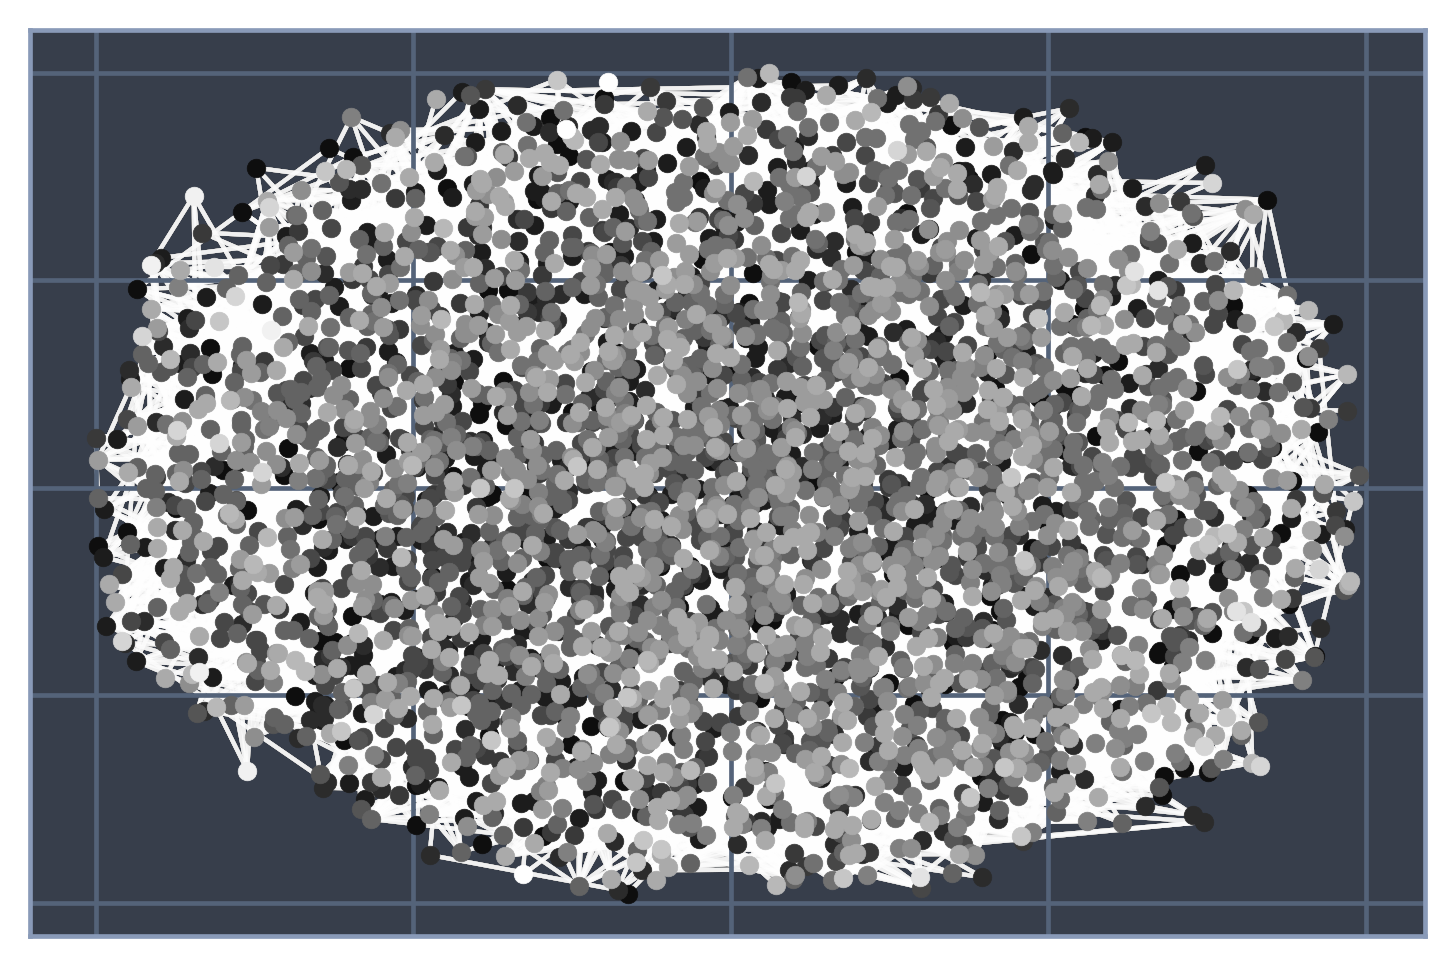

In [26]:
G1 = generate_G(df_allG, 2)
partition = community.best_partition(G1)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G1,k=1,iterations=20)

count = 0
for com in set(partition.values()):
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, list_nodes, node_size = 20, node_color = str(count / size))
    nx.draw_networkx_edges(G1, pos, edge_color = str(count / size), alpha=0.5)
plt.show()
# plot_network(G1, sub_sets[2])

# Playlist Feature Analysis

In [22]:
len(play_features)

3652

In [21]:
play_features = pd.read_csv('play_id_to_features.csv')
play_features['genre'] = df_allG['GENRE']
play_features.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,2JsqQdMbBC2hh7GjsEjKFg,0.222149,0.073075,4.38,-25.78303,0.66,0.041801,0.922340,0.899800,0.118957,0.095634,92.38971,3.60,backgroundmusic
1,2SoQc6bippmMyUTn1qditv,0.525410,0.645390,4.22,-9.24089,0.72,0.083043,0.468130,0.066672,0.282273,0.695130,119.71814,3.55,classicmoroccanpop
2,1KZMCWImik3vA17zVLJ3c3,0.213119,0.166708,5.39,-18.83644,0.56,0.039690,0.966740,0.210298,0.152561,0.144698,102.87562,3.69,orthodoxchant
3,1i9zTcQqWUBTgIuCgxDW3S,0.439940,0.348418,5.05,-12.84006,0.71,0.055323,0.896280,0.855150,0.141858,0.396229,107.26951,3.60,tar
4,0TcXdt4sbITbwCwwFbKYyd,0.789310,0.518160,5.14,-10.01960,0.53,0.133222,0.148952,0.111601,0.148528,0.736290,118.49993,4.00,reggae


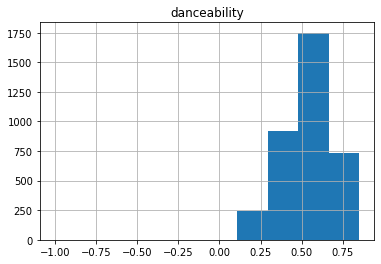

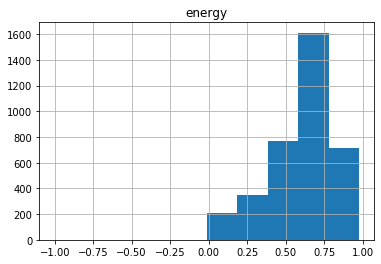

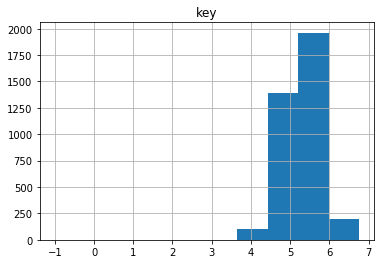

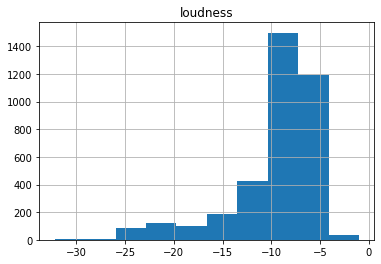

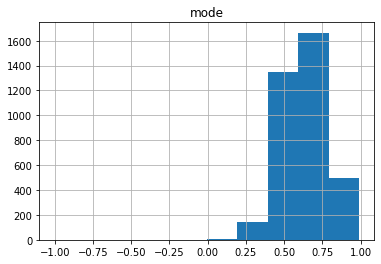

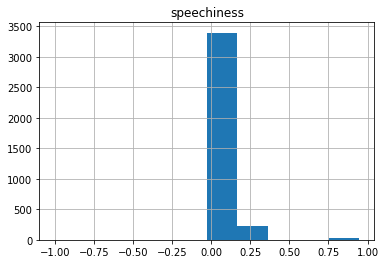

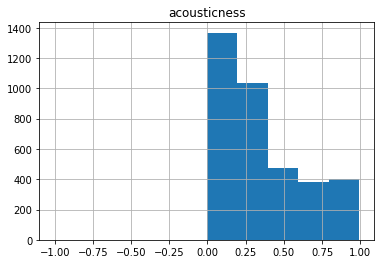

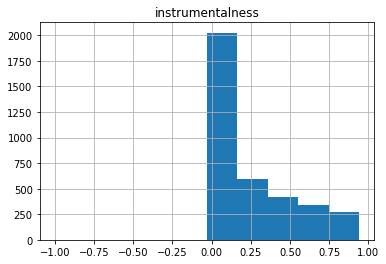

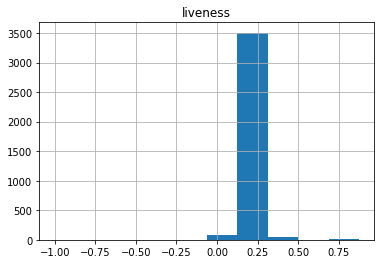

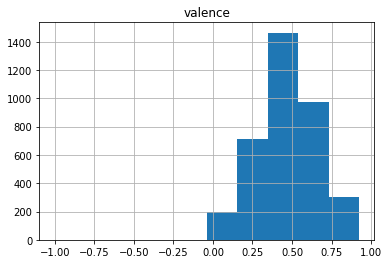

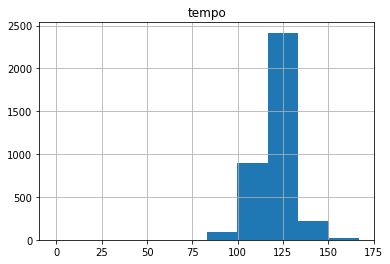

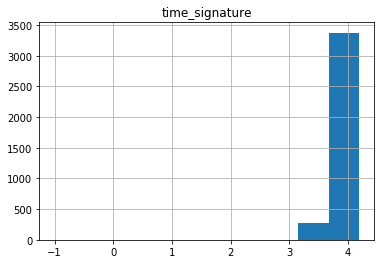

In [23]:
for f in features:
    plt.figure()
    play_features[f].hist()
    plt.title(f)
    plt.show()

# Feature Selection

It would appear looking at the distributions of the playlist tracks average values that a few features may be less meaningful. Looking at the above, we may find it useful to throw out time-signature, instrumentalness, speechiness, and mode. 

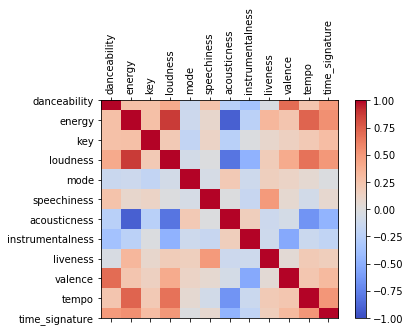

In [24]:
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
data = play_features[features]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [25]:
corr

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
danceability,1.000000,0.273655,0.266668,0.409840,-0.140372,0.252267,-0.240482,-0.359749,-0.042185,0.702354,0.239839,0.497665
energy,0.273655,1.000000,0.280308,0.875245,-0.118703,0.088885,-0.901963,-0.227776,0.333977,0.241860,0.730100,0.541326
key,0.266668,0.280308,1.000000,0.210908,-0.186546,0.121701,-0.237872,-0.022036,0.088420,0.146915,0.210076,0.295422
loudness,0.409840,0.875245,0.210908,1.000000,-0.074633,-0.011041,-0.806339,-0.478847,0.181243,0.404053,0.678895,0.503617
mode,-0.140372,-0.118703,-0.186546,-0.074633,1.000000,-0.058428,0.207911,-0.112492,0.161502,0.122734,0.056894,-0.022449
speechiness,0.252267,0.088885,0.121701,-0.011041,-0.058428,1.000000,-0.010669,-0.151062,0.497001,0.069558,-0.084915,0.073291
acousticness,-0.240482,-0.901963,-0.237872,-0.806339,0.207911,-0.010669,1.000000,0.166507,-0.117866,-0.067098,-0.651815,-0.468570
instrumentalness,-0.359749,-0.227776,-0.022036,-0.478847,-0.112492,-0.151062,0.166507,1.000000,-0.112688,-0.538447,-0.130146,-0.188515
liveness,-0.042185,0.333977,0.088420,0.181243,0.161502,0.497001,-0.117866,-0.112688,1.000000,0.044582,0.202154,0.169843
valence,0.702354,0.241860,0.146915,0.404053,0.122734,0.069558,-0.067098,-0.538447,0.044582,1.000000,0.226990,0.316006


In [29]:
corr <= -0.7

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
danceability,False,False,False,False,False,False,False,False,False,False,False,False
energy,False,False,False,False,False,False,True,False,False,False,False,False
key,False,False,False,False,False,False,False,False,False,False,False,False
loudness,False,False,False,False,False,False,True,False,False,False,False,False
mode,False,False,False,False,False,False,False,False,False,False,False,False
speechiness,False,False,False,False,False,False,False,False,False,False,False,False
acousticness,False,True,False,True,False,False,False,False,False,False,False,False
instrumentalness,False,False,False,False,False,False,False,False,False,False,False,False
liveness,False,False,False,False,False,False,False,False,False,False,False,False
valence,False,False,False,False,False,False,False,False,False,False,False,False


In [31]:
print('danceability and valence -- ' ,corr['danceability']['valence'])
print('energy and tempo -- ',corr['energy']['tempo'])
print('energy and loudness -- ',corr['energy']['loudness'])

print('energy and acousticness -- ',corr['energy']['acousticness'])
print('loudness and acousticness -- ',corr['loudness']['acousticness'])

danceability and valence --  0.7023535344309583
energy and tempo --  0.7300996278865707
energy and loudness --  0.8752448766630505
energy and acousticness --  -0.9019626557785377
loudness and acousticness --  -0.8063394007621765


# Feature Description

According to the Spotify Web API 

## Danceability
>	"Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."

## Speechiness
>   "Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks."

## Energy
>   "Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."

## Instrumentalness
>	"Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

## Key
> 	The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

## Liveness
> 	Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

## Loudness 
> 	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

>	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

>	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

>	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

>	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


# Feature Correlation

The above is a heatmap showing feature by feature correlation. 

The highest positive correlation is between energy and tempo which makes intuitive sense. Higher tempo may be a good indicator of energy, so we may not need to consider both of these features.

The correlation between danceability and valence

It is interesting that speechiness and danceability are more highly correlated than many of the other features.

Hmm.. that's interesting. Which genres are the ones with above 0.66 speechiness?

In [19]:
play_features[play_features['speechiness'] >= 0.6]

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
12,12,0.690,0.216,0.0,-12.642,1.0,0.914,0.649,0.0,0.121,0.591,102.668,5.0,rif
37,37,0.714,0.238,2.0,-16.086,0.0,0.947,0.903,0.0,0.282,0.432,129.432,3.0,artpop
39,39,0.688,0.326,8.0,-14.336,1.0,0.946,0.723,0.0,0.261,0.337,102.172,4.0,grimdeathmetal
40,40,0.677,0.196,1.0,-13.041,1.0,0.719,0.920,0.0,0.182,0.428,101.782,4.0,chiphop
